In [42]:
# 경고(warning) 메시지 비표시 설정
import warnings
warnings.filterwarnings("ignore")

# pandas 라이브러리 불러오기
import pandas as pd

In [43]:
use_log = pd.read_csv("./data/use_log.csv")
use_log.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [44]:
customer = pd.read_csv("./data/customer_join.csv")
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

# 클러스터링으로 회원을 그룹화하기

In [45]:
# 한달 이용 이력 데이터
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

In [47]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)

In [48]:
clusters.labels_

array([2, 2, 2, ..., 3, 3, 3], shape=(4192,), dtype=int32)

In [49]:
customer_clustering["cluster"] = clusters.labels_
customer_clustering["cluster"].unique()

array([2, 1, 0, 3], dtype=int32)

In [50]:
customer_clustering.head()

,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,2
1,5.083333,5.0,7,3,47,2
2,4.583333,5.0,6,3,47,2
3,4.833333,4.5,7,2,47,2
4,3.916667,4.0,6,1,47,2


# 클러스터링 결과 분석

In [51]:
customer_clustering.columns = ["월평균값", "월중앙값", "월최댓값", "월최솟값", "회원기간", "cluster"]
customer_clustering.head(2)

,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster
0,4.833333,5.0,8,2,47,2
1,5.083333,5.0,7,3,47,2


In [52]:
customer_clustering.groupby("cluster").count()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,1334,1334,1334,1334,1334
1,771,771,771,771,771
2,1249,1249,1249,1249,1249
3,838,838,838,838,838


In [53]:
customer_clustering.groupby("cluster").mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,5.541974,5.392804,8.757871,2.704648,14.857571
1,3.065504,2.900130,4.783398,1.649805,9.276265
2,4.677561,4.670937,7.233787,2.153723,36.915933
3,8.064079,8.050716,10.014320,6.180191,7.016706


# 군집화 결과 정리  
0번 군집 : 월 평균 이용횟수가 5.5번 이고 평균 가입기간이 14.8개월 이다.  
1번 군집 : 월 평균 이용횟수가 3.0번 이고 평균 가입기간이 9.2개월 이다. (주요 관리 대상으로 보여진다.)  
2번 군집 : 월 평균 이용횟수가 4.6번 이고 평균 가입기간이 36.9개월 이다. (고인물로 보인다.)  
3번 군집 : 월 평균 이용회수가 8.0번 이고 평균 가입기간이 7.0개월이다. (신규 회원으로 보인다. 가입뽐프 관리 필요.)  

군집의 결과를 분석하면 그룹별로 다른 캠페인을 사용 할 수 있을 것이다.  

In [54]:
# 차원 축소를 이용해 시각화 하기.
# 5차원 데이터를 2차원으로 축소해서 시각화 진행
from sklearn.decomposition import  PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)

In [55]:
pca_df["cluster"] = customer_clustering["cluster"]
pca_df.head()

,0,1,cluster
0,-0.819982,1.959097,2
1,-0.707922,1.799857,2
2,-1.061499,1.659826,2
3,-1.160764,1.810139,2
4,-2.017132,1.670101,2


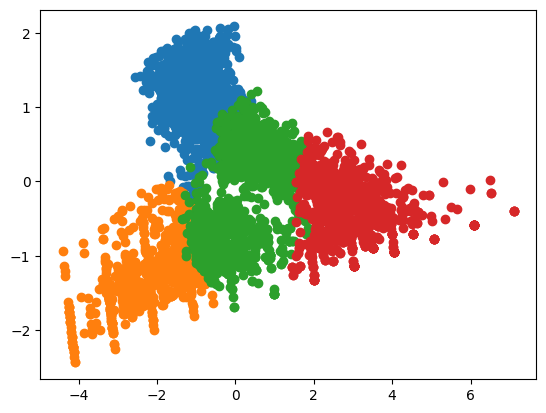

In [56]:
import matplotlib.pyplot as plt
for i in customer_clustering["cluster"].unique():
  tmp = pca_df.loc[pca_df["cluster"] == i]
  plt.scatter(tmp[0], tmp[1])

# 클러스터링 결과를 바탕으로 탈퇴회원 경향을 파악

In [57]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.head()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster,customer_id,name,class,gender,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,4.833333,5.0,8,2,47,2,OA832399,XXXX,C01,F,...,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,5.083333,5.0,7,3,47,2,PL270116,XXXXX,C01,M,...,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,4.583333,5.0,6,3,47,2,OA974876,XXXXX,C01,M,...,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,4.833333,4.5,7,2,47,2,HD024127,XXXXX,C01,F,...,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,3.916667,4.0,6,1,47,2,HD661448,XXXXX,C03,F,...,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [58]:
customer_clustering.groupby(["cluster", "is_deleted"], as_index=False)["customer_id"].count()

,cluster,is_deleted,customer_id
0,0,0,791
1,0,1,543
2,1,1,771
3,2,0,1231
4,2,1,18
5,3,0,820
6,3,1,18


# 탈퇴회원 경향  
2 번 군집의 경향 : 지속 회원이 많다. 회원 기간이 매우 길고 그룹 0번에 비해서 이용 횟수는 낮지만 안정적으로 보인다.  
1 번 군집의 경향 : 탈퇴 회원만 있다.  
0 번 군집의 경향 : 지속, 탈퇴의 비유이 비슷하다.  
3 번 군집의 경향 : 회원 기간이 짧지만 이용 횟구가 많이 의욕이 높아 보인다.  

In [59]:
# 정기적 비율 파악
# 0, 2 번 군집 : 정기 이용자의 비율이 많이 높다.
# 1 변 군집 : 비정기 이용자의 비율이 많이 높다.
customer_clustering.groupby(["cluster", "routine_flg"], as_index=False)["customer_id"].count()

,cluster,routine_flg,customer_id
0,0,0,227
1,0,1,1107
2,1,0,499
3,1,1,272
4,2,0,2
5,2,1,1247
6,3,0,51
7,3,1,787


# 다음달 이용횟수 예측을 위해 데이터 준비

In [60]:
use_log["usedate"] = pd.to_datetime(use_log["usedate"])
use_log["연월"] = use_log["usedate"].dt.strftime("%Y%m")
use_log.head()

,log_id,customer_id,usedate,연월
0,L00000049012330,AS009373,2018-04-01,201804
1,L00000049012331,AS015315,2018-04-01,201804
2,L00000049012332,AS040841,2018-04-01,201804
3,L00000049012333,AS046594,2018-04-01,201804
4,L00000049012334,AS073285,2018-04-01,201804


In [61]:
use_log_months = use_log.groupby(["연월", "customer_id"], as_index=False).count()
use_log_months.rename(columns={"log_id" : "count"}, inplace=True)
use_log_months.drop("usedate", axis=1, inplace=True)
use_log_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [62]:
# 레이블링 작업 : 최근 6개월 데이터를 가지고 다음달 이용 횟수를 종속변수로 지정
year_months = list(use_log_months["연월"].unique())
# print(len(year_months), year_months)
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    # print(year_months[i])
    tmp = use_log_months.loc[use_log_months["연월"] == year_months[i]]
    tmp.rename(columns={"count" : "count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = use_log_months.loc[use_log_months["연월"] == year_months[i - j]]
        # print(year_months[i - j])
        tmp_before.drop("연월", axis=1, inplace=True)
        tmp_before.rename(columns={"count" : "count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)

In [63]:
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [64]:
predict_data.shape

(18310, 9)

In [65]:
predict_data.isna().mean() * 100

연월              0.000000
customer_id     0.000000
count_pred      0.000000
count_0         2.823594
count_1         5.772802
count_2         8.732933
count_3        11.665756
count_4        14.434735
count_5        17.460404
dtype: float64

In [66]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.isna().mean() * 100

연월             0.0
customer_id    0.0
count_pred     0.0
count_0        0.0
count_1        0.0
count_2        0.0
count_3        0.0
count_4        0.0
count_5        0.0
dtype: float64

In [67]:
predict_data.shape

(15113, 9)

# 특징이 되는 변수를 추가

In [68]:
predict_data = pd.merge(
    predict_data, customer[["customer_id", "start_date"]], on="customer_id", how="left"
)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [69]:
predict_data["now_date"] = pd.to_datetime(predict_data["연월"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
predict_data.head(2)

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01


In [70]:
from dateutil.relativedelta import relativedelta
predict_data["preiod"] = None
for i in range(len(predict_data)):
  delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
  predict_data["preiod"][i] = delta.years * 12 + delta.months

In [71]:
import numpy as np
predict_data["preiod"] = predict_data["preiod"].astype(np.float16)

In [72]:
predict_data.head(2)

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,preiod
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35.0


# 다음달 횟수 예측 모델 학습

In [73]:
predict_data.columns

Index(['연월', 'customer_id', 'count_pred', 'count_0', 'count_1', 'count_2',
       'count_3', 'count_4', 'count_5', 'start_date', 'now_date', 'preiod'],
      dtype='object')

In [74]:
X = predict_data[["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "preiod"]]
y = predict_data["count_pred"]

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error, mean_squared_error, median_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [77]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print(lr_model.score(X_train, y_train))
print(lr_model.score(X_test, y_test))
# help(lr_model.score)
print(root_mean_squared_error(y_test, lr_pred))

0.20501906315417295
0.18961778851519395
1.6887155688423183


In [78]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
root_mean_squared_error(y_test, xgb_pred)

1.6698065996170044

# 종속 변수에 기여하는 독리변수가 뭔 확인

In [79]:
coef = pd.DataFrame({"feature_names" : X.columns, "coefficient": lr_model.coef_})
coef

,feature_names,coefficient
0,count_0,0.157875
1,count_1,0.152421
2,count_2,0.147920
3,count_3,0.120599
4,count_4,0.084131
5,count_5,0.022934
6,preiod,0.005686


# 다음달 이용횟수 예측

In [87]:
# x_user = [[3,4,6,3,6 ,9,11]]
x_user1 = [3,7,3,7,9,10,11]
x_user2 = [3, 4, 6, 3, 6, 9, 11]
x_user = [x_user1,x_user2]

In [88]:
lr_model.predict(x_user)

array([5.07651489, 4.3052874 ])

In [89]:
use_log_months.to_csv("./data/use_log_months.csv",index=False)